## Exploring forecasting various home price metric with pytorch
see: 
- https://github.com/jdb78/pytorch-forecasting
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html 


In [1]:
# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import (
    Baseline,
    TimeSeriesDataSet,
    TemporalFusionTransformer,
    QuantileLoss,
)
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer, NaNLabelEncoder
from capston_db_conn import db_conn
import torch

conn = db_conn()
# print(conn)

# standard imports
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
rf_sql = """
select
*
from redfin_county_full
"""
# NOTE: add filters on SQL query once determined they are needed

redfin = pd.read_sql(rf_sql, con=conn, parse_dates=["period_start", "period_end"])
# conn.close()


In [3]:
redfin = redfin.dropna(subset=["median_sale_price"])
redfin.head()


,county_fips,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated,county
0,06047,2021-06-01,2021-06-30,30,county,5,326,f,"Merced County, CA",None,...,NaN,NaN,NaN,0.000000,-0.500000,-1.000000,"Merced, CA",32900.0,2022-01-09 14:29:56,Merced County
1,37135,2017-02-01,2017-02-28,30,county,5,2074,f,"Orange County, NC",None,...,0.180000,0.066364,0.039155,0.125000,0.125000,0.025000,"Durham, NC",20500.0,2022-01-09 14:29:56,Orange County
2,53055,2020-08-01,2020-08-31,30,county,5,3097,f,"San Juan County, WA",None,...,0.222222,0.122222,NaN,0.000000,0.000000,NaN,Washington nonmetropolitan area,NaN,2022-01-09 14:29:56,San Juan County
3,55133,2019-11-01,2019-11-30,30,county,5,3230,f,"Waukesha County, WI",None,...,0.163328,-0.087474,-0.035511,0.066845,-0.019902,-0.014660,"Milwaukee, WI",33340.0,2022-01-09 14:29:56,Waukesha County
4,26151,2018-09-01,2018-09-30,30,county,5,1423,f,"Sanilac County, MI",None,...,0.229592,-0.040450,0.006242,0.229167,-0.059722,-0.064951,Michigan nonmetropolitan area,NaN,2022-01-09 14:29:56,Sanilac County


In [4]:
cols = [
    "region",
    #"county_fips",
    "period_end",
    "property_type",
    #"property_type_id",
    "median_sale_price",
    "median_list_price",
    "median_ppsf",
    "median_list_ppsf",
    "homes_sold",
    "pending_sales",
    "new_listings",
    "inventory",
    "months_of_supply",
    "median_dom",
    "avg_sale_to_list",
    "sold_above_list",
    #"price_drops",
    "off_market_in_two_weeks",
]

In [5]:
# load data: this is pandas dataframe with at least a column for
# * the target (what you want to predict)
# * the timeseries ID (which should be a unique string to identify each timeseries)
# * the time of the observation (which should be a monotonically increasing integer)
data = redfin[cols]

# add time index
data["time_idx"] = data["period_end"].dt.year * 12 + data["period_end"].dt.month
data["time_idx"] -= data["time_idx"].min()
data["month"] = data["period_end"].dt.month.astype(str).astype("category")

In [6]:
data = data.dropna()
data.head()

,region,period_end,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,time_idx,month
0,"Merced County, CA",2021-06-30,Condo/Co-op,267500.0,370000.0,193.726937,230.789278,4.0,2.0,3.0,5.0,1.3,18.0,1.005180,0.500000,0.000000,113,6
1,"Orange County, NC",2017-02-28,Condo/Co-op,165750.0,395000.0,156.623674,163.105413,12.0,8.0,18.0,50.0,4.2,93.0,0.966541,0.083333,0.125000,61,2
2,"San Juan County, WA",2020-08-31,Condo/Co-op,458500.0,714500.0,349.231202,398.935457,2.0,3.0,5.0,9.0,4.5,237.0,0.973913,0.000000,0.000000,103,8
3,"Waukesha County, WI",2019-11-30,All Residential,305000.0,285000.0,150.964010,156.313559,461.0,374.0,300.0,1298.0,2.8,56.0,0.984271,0.253796,0.066845,94,11
4,"Sanilac County, MI",2018-09-30,Single Family Residential,138500.0,129900.0,86.734694,80.393333,49.0,48.0,45.0,196.0,4.0,63.0,0.929679,0.183673,0.229167,80,9


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457071 entries, 0 to 563119
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   region                   457071 non-null  object        
 1   period_end               457071 non-null  datetime64[ns]
 2   property_type            457071 non-null  object        
 3   median_sale_price        457071 non-null  float64       
 4   median_list_price        457071 non-null  float64       
 5   median_ppsf              457071 non-null  float64       
 6   median_list_ppsf         457071 non-null  float64       
 7   homes_sold               457071 non-null  float64       
 8   pending_sales            457071 non-null  float64       
 9   new_listings             457071 non-null  float64       
 10  inventory                457071 non-null  float64       
 11  months_of_supply         457071 non-null  float64       
 12  median_dom      

In [32]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 60
max_prediction_length = 12
training_cutoff = data["time_idx"].max() - max_prediction_length  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # column name of time of observation
    target="median_sale_price",  # column name of target to predict
    group_ids=["region", "property_type"],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=["region","property_type"],
    static_reals=[],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=[],
    time_varying_known_reals=[], # this is where tax rate would go
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "median_sale_price",
        "median_list_price",
        "median_ppsf",
        "median_list_ppsf",
        "homes_sold",
        "pending_sales",
        "new_listings",
        "inventory",
        "months_of_supply",
        "median_dom",
        "avg_sale_to_list",
        "sold_above_list",
        "off_market_in_two_weeks",
    ],
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
    categorical_encoders={"region":NaNLabelEncoder(add_nan=True)}
)
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    # add_target_scales=True,
    # add_encoder_length=True,
# )


In [33]:
training.get_parameters() 

{'time_idx': 'time_idx',
 'target': 'median_sale_price',
 'group_ids': ['region', 'property_type'],
 'weight': None,
 'max_encoder_length': 60,
 'min_encoder_length': 60,
 'min_prediction_idx': 0,
 'min_prediction_length': 12,
 'max_prediction_length': 12,
 'static_categoricals': ['region', 'property_type'],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['median_sale_price',
  'median_list_price',
  'median_ppsf',
  'median_list_ppsf',
  'homes_sold',
  'pending_sales',
  'new_listings',
  'inventory',
  'months_of_supply',
  'median_dom',
  'avg_sale_to_list',
  'sold_above_list',
  'off_market_in_two_weeks'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': EncoderNormalizer(transfor

In [34]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True,
)

In [35]:
# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=2
)

In [36]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


48131.4375

In [37]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs"),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# define network to train - the architecture is mostly inferred from the dataset,
# so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=0,
    # optimizer parameters
    learning_rate=0.03,#change back to best_tft
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 140.2k


Finding best initial lr:  30%|███       | 30/100 [00:09<00:20,  3.41it/s]/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:  60%|██████    | 60/100 [00:29<00:11,  3.42it/s]/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:  90%|█████████ | 90/100 [00:50<00:02,  3.39it/s]/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding be

suggested learning rate: 0.03199598552239528


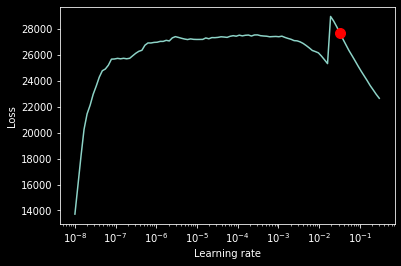

In [39]:
# find the optimal learning rate
res = trainer.tuner.lr_find(
    tft, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    early_stop_threshold=1000.0,
    max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [40]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 53.7 K
3  | prescalers                         | ModuleDict                      | 448   
4  | static_variable_selection          | VariableSelectionNetwork        | 294   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 29.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial

Epoch 0:  78%|███████▊  | 46/59 [00:19<00:05,  2.35it/s, loss=2.79e+04, v_num=0, train_loss_step=2.9e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  78%|███████▊  | 46/59 [00:40<00:11,  1.12it/s, loss=2.79e+04, v_num=0, train_loss_step=2.76e+4, val_loss=4.42e+4, train_loss_epoch=2.77e+4]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  78%|███████▊  | 46/59 [01:03<00:17,  1.37s/it, loss=2.51e+04, v_num=0, train_loss_step=8.07e+3, val_loss=4.37e+4, train_loss_epoch=2.77e+4]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3:  78%|███████▊  | 46/59 [01:25<00:24,  1.86s/it, loss=6.57e+04, v_num=0, train_loss_step=9.79e+5, val_loss=1.56e+4, train_loss_epoch=2.55e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3: 100%|██████████| 59/59 [01:26<00:00,  1.47s/it, loss=6.57e+04, v_num=0, train_loss_step=9.79e+5, val_loss=1.11e+5, train_loss_epoch=4.67e+4]

Finding best initial lr:   1%|          | 1/100 [05:47<9:33:51, 347.79s/it]

Epoch 3: 100%|██████████| 59/59 [01:47<00:00,  1.82s/it, loss=6.57e+04, v_num=0, train_loss_step=9.79e+5, val_loss=1.11e+5, train_loss_epoch=4.67e+4]

In [ ]:
# # load the best model according to the validation loss
# # (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [42]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader) #change back to best_tft
(actuals - predictions).abs().mean()

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


tensor(224329.5000)

In [43]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True) #change back to best_tft

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


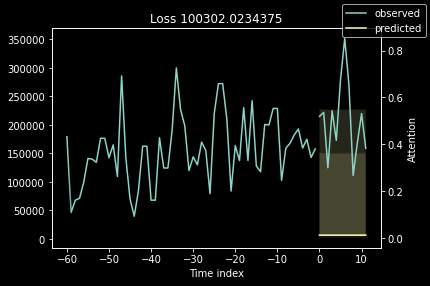

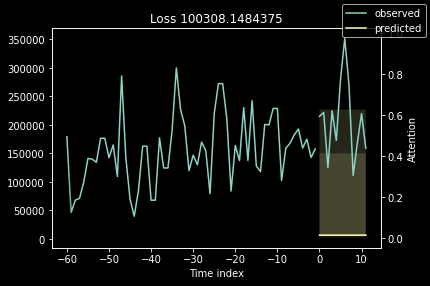

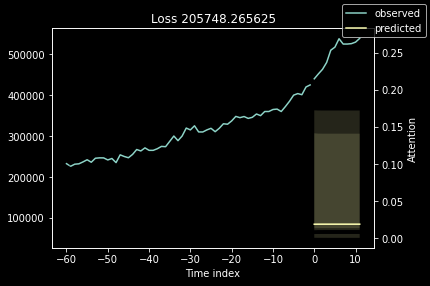

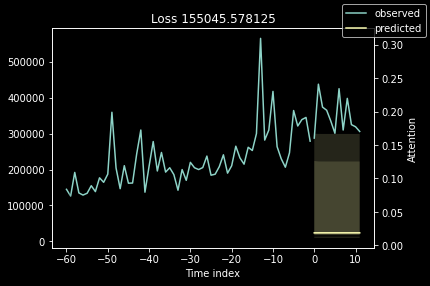

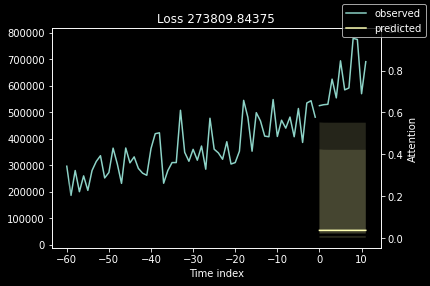

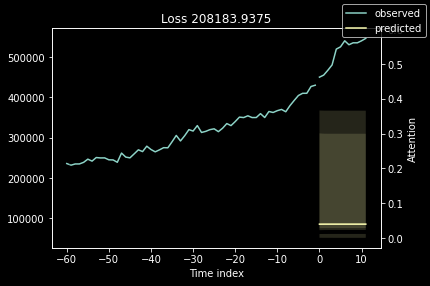

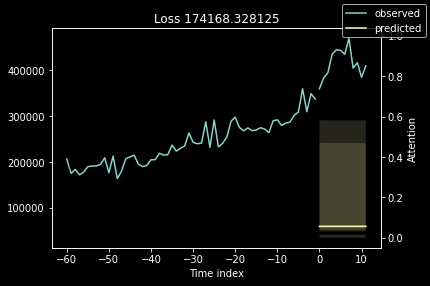

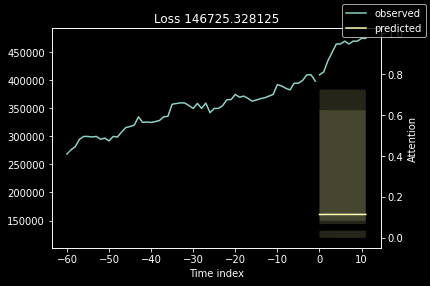

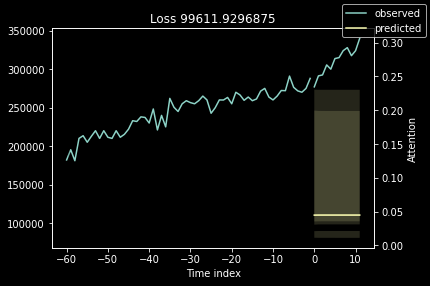

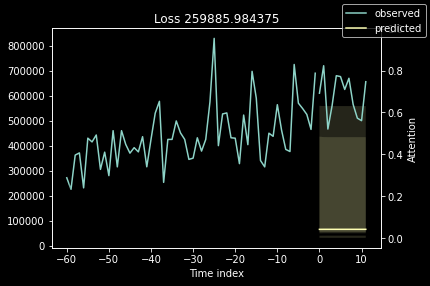

In [44]:
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True); #change back to best_tft